## Sequência de funções valor para os credores

Queremos resolver por indução retroativa um jogo com T períodos.

Estou trabalhando em como deixar esse jogo em torno do parâmetro T

Teremos duas sequências de funções valor: uma para quando apenas o credor sênior propõe e outra para quando apenas o credor júnior propõe. As funções do jogo final serão uma média ponderada destas.



In [37]:
#para mostrar todos os resultados e não apenas o último
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [38]:
#libraries
import numpy as np
from numba import jit, jitclass, float64, njit
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
from scipy.stats import beta

import math

### Passo 0: definindo comandos do latex para facilitar a escrita

$%conjunto de informações de s em t$
$\newcommand{\Is}[1]{\theta_{s{#1}}, l_{s{#1}}, l_{j{#1}}}$
$%macros para facilitar a escrita de funções valor$


$%conjunto de informações de j em t$
$\newcommand{\Ij}[1]{\theta_{j{#1}}, l_{s{#1}}, l_{j{#1}}}$

$%função valor de s em t$
$\newcommand{\Ws}[1]{ W_{s{#1}} ( \Is{{#1}}) }$

$%função valor de j em t$
$\newcommand{\Wj}[1]{ W_{j{#1}} ( \Ij{{#1}}) }$

$%operador esperança de s em t. 2 argumentos: o primeiro é o período e o segundo é o termo que ela tira a esperança$

$\newcommand{\Es}[2]{\mathbb{E_{#1}^{s} \big[ {#2}  \mid ( \Is{#1} )    \big] }}$

$%minúsculo não mostra o conjunto de informação$
$\newcommand{\es}[2]{\mathbb{E_{#1}^{s} \big[ {#2}  \big] }}$

$%minúsculo não mostra o conjunto de informação$
$%final b de big para aumentar os parênteses$
$\newcommand{\esb}[2]{\mathbb{E_{#1}^{s} \bigg[ {#2}  \bigg] }}$

$%operador esperança de j em t. 2 argumentos: o primeiro é o período e o segundo é o termo que ela tira a esperança$

$\newcommand{\Ej}[2]{\mathbb{E_{#1}^{j} \big[ {#2}  \mid ( \Ij{#1} )    \big] }}$

$%minúsculo não mostra o conjunto de informação$
$\newcommand{\ej}[2]{\mathbb{E_{#1}^{j} \big[ {#2}  \big] }}$

$%minúsculo não mostra o conjunto de informação$
$%final b para aumentar os parênteses$
$\newcommand{\ejb}[2]{\mathbb{E_{#1}^{j} \bigg[ {#2}  \bigg] }}$


$%comando para usar o máximo com chaves grandes$
$\newcommand{\maximo}[1]{\max \bigg\{ #1 \bigg\}}$


In [39]:
#parâmetros do jogo, apenas para ilustração a princípio



μ = 3 #número de meses entre períodos, não entendi onde entra ainda
ρ = 0.9 # (1 - ρ) é a taxa de depreciação da empresa a cada período
β = 1 #usamos aqui a distribuição Uniforme, depois vamos mudar isto
c0 = 0.05 #custo fixo de ir para a corte
c1 = 0.015 #custo variável de ir para a corte




λj = 0.5 #probabilidade de j propor a cada turno. Não precisaremos estimar, isso virá dos dados


θ_s0 = 0.5 #habilidade inicial de s
θ_j0 = 0.5 #habilidade inicial de j

In [40]:
#informações que virão dos dados

Vmax = 100
L = 20 
L_s = 10
L_j = 10

#valores da dívida de cada jogador (virá dos dados, aqui é exemplo):
Ds = 20
Dj = 10

### Qual o ganho que o credor s tem em propor a cada período?

Suponha que ele vai propor reorganizar a firma no perído t. A reorganização demora 1 período, então o valor da firma aparece no próximo período, $V_{t+1}$. E ele precisa fazer uma estimativa sobre $\theta_{s,t+1}$ dada a informação que ele tem no período atual, que eu chamei de k: $\theta_{s,k}$:

$$ R_t (\theta_{s,k}) = V_{t+1} \bigg( \mathbb{E}_k^s \big[ \theta_{s,t+1} \mid \theta_{s,k} \big] \bigg) - L_j$$


#### Qual a estimativa da habilidade dele nos períodos à frente dada a informação dele hoje?

Essa parte depende da hipótese sobre a distribuição da habilidade.

Se supormos que a habilidade segue distribuição Uniforme, a forma fechada dela é:

Suponha $ t > k$

$$ \mathbb{E}_k^s \big[ \theta_{s,t} \mid \theta_{s,k} \big] =  \frac{\theta_{s,k}} {2^{t - k}} + \sum_{n=1}^{t - k} \frac{1}{2^{n}} $$


#### Quais os passos do algoritmo para implementar essa estratégia?

1. Calcular todos os valores de reorganização $ R_t $ de $ t \in  \{k, k+1, ..., T\}$ e também o valor de nunca reorganizar, que é $L_s$

2. Criar uma condição para checar se $\max \{R_{k}, R_{k+1}, ..., R_{T}, L_s \} = R_{k}$
    * em caso positivo, oferecer $P_s = W_{j, t+1} = L_j$ a fim de reorganizar a firma
    * em caso negativo, oferecer $P_s < W_{j, t+1} = L_j$ a fim de adiantar o jogo até o próximo período
    
3. Repetir os passos 1 e 2 até que reorganize a firma ou o jogo termine com ela liquidada

### Passo 1: número máximo de turnos

Calculado com base nos parãmetros

In [41]:
#função para calcular o máximo de turnos do jogo
def maximo_de_turnos(ρ, Vmax, L):
    
    t = 1
    
    while ρ**t * Vmax > L:
        
        t = t + 1
        
    return t
    

In [42]:
#guardando o número máxim de turnos

T = maximo_de_turnos(ρ, Vmax, L)

T

16

In [43]:
#valor máximo de reorganização da firma a cada período


#sequência de valores da firma para cada período

V = np.empty(T, dtype=np.int_)

for t in range(T):

    V[t] = ρ**t * Vmax

In [44]:
#valor de liquidação


#a dívida total é sempre a soma das dívidas
D = Ds + Dj

#o custo total é uma função do tempo

def C(t):
    Ct = c0 * D + c1 * t * D
    
    return Ct

#e os valores de liquidação também são função do tempo

def Ls(t):
    
    Lst = min(L - C(t), Ds)
    
    return Lst

def Lj(t):
    
    Ljt = min(L - C(t) - Ls(t), Dj)
    
    return Ljt
    
    


In [45]:
V[0] #é o primeiro valor do negócio

V[15]

100

20

In [46]:
Ls(2)

17.6

### Passo 2: definir as funções valor de liquidação e as matrizes para guardar seus valores


$$ W_{s1} (\Is{1}) = (1 - \lambda_j) S_1 (\Is{1}) + (\lambda_j) s_1 (\Is{1}) $$

A primeira parte da função valor de s é caso ele venha a propor:


 $$ S_1 (\Is{1}) = \max \bigg\{ L_{s1}, V \es{1}{\theta_s} - \es{1}{W_j}, \es{1}{W_s}
                    \bigg\} $$



In [47]:
#precisamos dos valores de cada theta e cada l para calcular essa função

Ws = np.empty(T, dtype=np.int_)

Wj = np.empty(T, dtype=np.int_)

ls = np.empty(T, dtype=np.int_)

lj = np.empty(T, dtype=np.int_)

θs = np.empty(T, dtype=np.int_)

θj = np.empty(T, dtype=np.int_)


#os valores de continuação no nó final são os valores de liquidação
Ws[T-1] = Ls(T-1)
Wj[T-1] = Lj(T-1)




### Função para tirar os valores esperados de t períodos à frente

Essa é a base do jogo. Vamos começar com a Uniforme mesmo por ser mais fácil de computar (e verificar), depois eu mudo o código para considerar a Beta.

In [48]:
#função para calcular a esperança da habilidade nos períodos à frente
def expec(h, k, t):
    #h é a informação hoje, usada para prever a habilidade
    #k é o período de hoje
    #t é o período para o qual eu desejo estimar a habilidade
    
    #somatório de n até t-k
    summation = 0
    for i in range(1, t-k+1):      
        summation += 2**-i
    
    resultado = h/2**(t-k) + summation
    
    return resultado
    
# expec(0.5, 1, 4) #ok com os meus cálculos

#como ficaria um gráfico dessa função?


In [49]:
expec(θ_s0, 1, (T-1))

0.999969482421875

In [50]:

#aqui a notação está em contagem regressiva novamente
#aqui é o valor do que ele faz
S1 = [Ls((T-1)), V[T-1-1] * expec(θ_s0, 1, (T-1)) - Wj[T-1], Ws[T-1]]


#aqui é o que ele faz. Como policy_S1 é igual a 1, significa que ele propõe reorganizar pagando PS1 = Wj[T-1]
policy_S1 = np.argmax(S1)


S1 = S1[policy_S1]

Es_S1 = S1

A segunda parte da função valor é se se for chamado a responder:
    
$s_1 (\Is{1}) = $
    $ \esb{1}{ Prob ({j liquidar})  \maximo{L_{s1}, V \es{1}{\theta_s} - L_{j1}} } $
    $ + \esb{1}{ Prob ({j reorganizar})   \maximo{\ej{1}{W_s}, \es{1}{W_s}}    }$
 
 
 Sendo que
 
 $ \Es{1}{Prob (j liq em T-1)}$
 
  $$ = Prob \bigg(L_{j1} > \max \{V \es{1}{ \ej{1}{\theta_j} } - \es{1}{ \ej{1}{W_s} }, \es{1}{ \ej{1}{W_j}  }\} \bigg)$$
  
  
 Repare que $L_{j1} > L{j}$ e que $\es{1}{\theta_{j}}$ cresce em $\theta_{j}$. Então deve existir um threshold de reorganização em t = T-1, $\phi_{j1}$, tal que: 

$$V \phi_{j1} - L_{s} = L{j1} $$

$$ \phi_{j1} = \frac{ L_{j1} + L_{s} }{V} $$

Então se $\es{1}{\theta_{j}} > \phi_{j1}$, j reorganiza a firma. E j liquida a firma caso contrário.


A pergunta é: qual a probabilidade de que $\theta_{j}$ tome um valor menor ou igual a $\phi_{j1}$ ? Isso pode ser respondido usando a \textit{prior} do jogador, a função CDF da distribuição Beta:

$$ \Es{1}{Prob (\textnormal{j liq em T-1})} = F_{\beta} \big( \phi_{j1} \mid l_{j1} \big) $$
 


In [51]:
#s1
#Prob_s1 é a probabilidade de l liquidar em t-1, de acordo com o credor sênior (s)


# Prob_s1 

ϕj1 = ( Lj((T-1)) + Ws[T-1] ) / V[T-1]

ϕj1

lj1 = 0.5 #endogeneizar depois


Prob_s1 = 1 - ((1 - ϕj1)**β)/((1 - lj1)**β)

Prob_s1

# a probabilidade de reorganizar será o complementar.

0.55

0.10000000000000009

Agora o valor esperado caso j liquide. No paper isto é 

$  \maximo{L_{s1}, V \es{1}{\theta_s} - L_{j1}}  $

Repare que s quer prever a habilidade dele próprio no período final, então podemos usar a habilidade dele no período T-1 para isso

In [52]:
#vamos criar um vetor de expectativas de s para a sua própria habilidade.

Es_θs = np.ones(T)

#popular esse vetor de expectativas com todos os períodos dali pra frente

θ_s_atual = θ_s0

for i in range(t, T-1):
    
    Es_θs[i-1] = expec(θ_s_atual, t, i)
    

    
Es_θs 

#agora vamos calcular o payoff esperado no caso de j propor liquidação

s1_liq = [Ls((T-1)), V[T-1-1] * Es_θs[T-1] - Lj((T-1)) ]


#aqui é o que ele faz. Como policy_S1 é igual a 1, significa que ele propõe reorganizar pagando PS1 = Wj[T-1]
policy_s1_liq = np.argmax(s1_liq)


s1_liq = s1_liq[policy_s1_liq]


#caso j liquide em T-1, a política ótima é propor reorganizar, o que lhe dá payoff de 22
policy_s1_liq 

s1_liq


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

1

22.0

Agora, o payoff esperado de s caso j decida reorganizar a firma

$ \maximo{\ej{1}{W_s}, \es{1}{W_s}}    $

In [53]:
#agora vamos calcular o payoff esperado no caso de j propor reorganização

s1_reorg = [Ws[T-1], Ws[T-1]]


#aqui é o que ele faz. Como policy_S1 é igual a 1, significa que ele propõe reorganizar pagando PS1 = Wj[T-1]
policy_s1_reorg = np.argmax(s1_reorg)


s1_reorg = s1_reorg[policy_s1_reorg]


#caso j proponha liquidar em T-1, a política ótima é propor reorganizar, o que lhe dá payoff de 22
policy_s1_reorg 

s1_reorg

0

11

A função s1 torna-se então:



In [54]:
#s1 completa

Es_s1 = (Prob_s1) * ( s1_liq) + (1 - Prob_s1) * s1_reorg 




### Como resumir isso?

A função valor no período t é função de lst, ljt e theta_t. Vamos construir uma função que calcula a função valor de cada período para valores arbitrários destas três variáveis.


Passos:

1. Vamos escrever as funções St, st, Jt e jt.

2. Vamos colocar essas funções como argumentos das funções valor

3. Vamos testar as funções valor e ver o que funciona e o que não.


PROBLEMA: as funções ainda estão em função de Wj[t] e Ws[t]



In [55]:
#payoff de S quanto ele tem o direito de propor em t

#aqui eu colo Wj[t] e Ws[t] como argumentos. 
#Tem que ter preparado o terreno antes calculando as funções valor no período seguinte

def St(teta_st, lst, ljt, t):
    
    St = [Ls(t), V[t] * expec(teta_st, t, (t+1)) - Wj[t], Ws[t]]
    
    policy_St = np.argmax(St)
    
    
    
    return (St[policy_St])


    

    


In [56]:
#testando para t = 15, que já sabemos Wj e Ws

St(0.5, 0.5, 0.5, 15)

15.0

In [57]:
#vamos criar os componentes da função st

#probabilidade de j liquidar em t, dado ljt 
def Prob_s(ljt,t):

    #threshold para j tentar liquidar
    ϕjt = ( Lj(t) + Ws[t] ) / V[t]
    
    Prob_st = 1 - ((1 - ϕjt)**β)/((1 - ljt)**β)
    
    #aqui tem que ser no mínimo a igual a zero, apenas por segurança
    
    Prob_st = max(0, Prob_st)
    
    return Prob_st



In [58]:
#payoff caso s responda à uma proposta de liquidação de j


def s_liq(teta_st, lst, ljt, t):
    
    st_liq = [Ls(t), V[t] * expec(teta_st, t, (t+1)) - Lj(t) ]

    policy_st_liq = np.argmax(st_liq)


    st_liq = st_liq[policy_st_liq]

    return (st_liq)




In [59]:
#testando para t = 15

Prob_s(0.5, 15)

s_liq(0.3, 1, 1, 15)

0.10000000000000009

13.0

In [60]:
#payoff caso s responda à uma proposta de reorganização de j

def s_reorg(teta_st, lst, ljt, t):
    
    st_reorg = [Ws[t], Ws[t]]

    policy_st_reorg = np.argmax(st_reorg)


    st_reorg = st_reorg[policy_st_reorg]
    
    return (st_reorg)



In [61]:
#testando para t = 15

s_reorg(0.6, 0.5, 0.5, 15)

#de fato a habilidade não muda s_reorg em t = 15 porque o próximo período é de liquidação
#nos outros períodos isso deve mudar

11

In [62]:
def st(teta_st, lst, ljt, t):
    
    #agregando todas as funções até agora
    
    st = (Prob_s(ljt,t)) * s_liq(teta_st, lst, ljt, t) + (1 - Prob_s(ljt,t)) * s_reorg(teta_st, lst, ljt, t)
    
    return (st)

In [63]:
#testando para t = 15

st(0.6, 0.5, 0.5, 15)



11.5

In [64]:
#finalmente, a função valor de s no período t
#defini com subscrito _val porque o vetor Ws é argumento das funções serão passadas como argumento aqui

#havia uma confusão entre Ws função e Ws vetor

#percebi o erro com o link abaixo
#https://stackoverflow.com/questions/32446402/typeerror-function-object-is-not-subscriptable-in-python-3-4-3


def Ws_val(teta_st, lst, ljt, t):
    
    
    Wst = (1- λj) * St(teta_st, lst, ljt, t) + (λj)  * st(teta_st, lst, ljt, t)
    
    return Wst

In [65]:
#testando para t = 15



Ws_val(0.5, 0.5, 0.5, 15)

#it works!!!!




13.2

### Criando as funções valor para J


É análogo ao s, então vou colocar só a descrição geral aqui. Basicamente, é só trocar s por j nos argumentos

$$ W_{jt} (\Ij{t}) = (1 - \lambda_j) j_t (\Ij{t}) + (\lambda_j) J_t (\Ij{t}) $$


A primeira parte da função valor de j é caso ele venha a propor:


$$ J_t (\Ij{t}) = \max \bigg\{ L_{jt}, V_{t+1} \ej{t}{\theta_{j, t+1} }  - \ej{t}{W_{s, t+1}  }, \ej{t}{W_{j,t+1} } \bigg\} $$


A segunda parte da função valor é se se for chamado a responder:
    
$j_t (\Ij{t}) = $
    $ \ejb{t}{ Prob ({s liquidar})  \maximo{L_{j,t}, V_{t+1} \ej{t}{\theta_{j,t+1}  } - L_{s, t} } } $
    $ + \ejb{t}{ Prob ({j reorganizar})   \maximo{\es{t}{W_{j, t+1} }, \ej{t}{W_{j, t+1} } }  }$
 
 


In [66]:
#payoff de S quanto ele tem o direito de propor em t

#aqui eu colo Wj[t] e Ws[t] como argumentos. 
#Tem que ter preparado o terreno antes calculando as funções valor no período seguinte

def Jt(teta_jt, lst, ljt, t):
    
    Jt = [Lj(t), V[t] * expec(teta_jt, t, (t+1)) - Ws[t], Wj[t]]
    
    policy_Jt = np.argmax(Jt)
    
    
    
    return (Jt[policy_Jt])


    

    


In [67]:
#testando para t = 15, que já sabemos Wj e Ws

Jt(0.5, 0.5, 0.5, 15)

4.0

In [68]:
#vamos criar os componentes da função st

#probabilidade de j liquidar em t, dado ljt 
def Prob_j(lst,t):

    #threshold para s tentar liquidar
    ϕst = ( Ls(t) + Wj[t] ) / V[t]
    
    Prob_jt = 1 - ((1 - ϕst)**β)/((1 - lst)**β)
    
    #aqui tem que ser no mínimo a igual a zero, apenas por segurança
    
    Prob_jt = max(0, Prob_jt)
    
    return Prob_jt



In [69]:
#payoff caso j responda à uma propojta de liquidação de j


def j_liq(teta_jt, lst, ljt, t):
    
    jt_liq = [Lj(t), V[t] * expec(teta_jt, t, (t+1)) - Ls(t) ]

    policy_jt_liq = np.argmax(jt_liq)


    return jt_liq[policy_jt_liq]




In [70]:
#testando para t = 15

Prob_j(0.5, 15)

j_liq(0.3, 1, 1, 15)

0.17500000000000004

1.25

In [71]:
#payoff caso s responda à uma proposta de reorganização de j

def j_reorg(teta_jt, lst, ljt, t):
    
    jt_reorg = [Wj[t], Wj[t]]

    policy_jt_reorg = np.argmax(jt_reorg)


    jt_reorg = jt_reorg[policy_jt_reorg]
    
    return (jt_reorg)



In [72]:
#testando para t = 15

j_reorg(0.6, 0.5, 0.5, 15)

#de fato a habilidade não muda s_reorg em t = 15 porque o próximo período é de liquidação
#nos outros períodos isso deve mudar

0

In [73]:
def jt(teta_jt, lst, ljt, t):
    
    #agregando todas as funções até agora
    
    jt = (Prob_j(lst,t)) * j_liq(teta_jt, lst, ljt, t) + (1 - Prob_j(lst,t)) * j_reorg(teta_jt, lst, ljt, t)
    
    return (jt)

In [74]:
#testando para t = 15

jt(0.6, 0.5, 0.5, 15)



0.7437500000000001

In [75]:
#finalmente, a função valor de s no período t
#defini com subscrito _val porque o vetor Ws é argumento das funções serão passadas como argumento aqui

#havia uma confusão entre Ws função e Ws vetor

#percebi o erro com o link abaixo
#https://stackoverflow.com/questions/32446402/typeerror-function-object-is-not-subscriptable-in-python-3-4-3


def Wj_val(teta_jt, lst, ljt, t):
    
    
    Wjt = (1- λj) * jt(teta_jt, lst, ljt, t) +  (λj) * Jt(teta_jt, lst, ljt, t)
    
    return Wjt

In [76]:
#testando para t = 15



Wj_val(0.5, 0.5, 0.5, 15)

#it works!!!!




2.284375

#### Vamos montar a matriz com os valores das funções valor

Isso porque cada função valor é função dela mesma no período seguinte. Vamos resolver de trás pra frente e guardar as funções de cada período para permitir que calculemos o período anterior.

As dimensões são:

teta, ls, lj, T


No artigo, as estimativas são de teta_s0 = 0.281 e teta_j0 = 0.364, então vou trabalhar com três casas decimais.

# a parte abaixo trava o computador, por isso deixei toda em comentário

In [73]:
# #coloquei 1000 de dimensão para ter três casas decimais

# grid_size = 1000

# #problema computacional fazer uma matriz gigante com quarta dimensão T. Mesmo se fosse quarta dimensão = 2,
# #não tem memória suficiente
# Matriz_Ws =  np.zeros((grid_size,grid_size,grid_size))


# Matriz_Wj =  np.zeros((grid_size,grid_size,grid_size))

No último período, independente de habilidade ou o que seja, o valor das funções valor é o valor de liquidação:




In [ ]:
# #os valores de continuação no nó final são os valores de liquidação, independente das habilidades
# Matriz_Ws[:,:,:,T-1] = Ls(T)
# # 

# Matriz_Wj[:,:,:,T-1] = Lj(T)

In [65]:
#então para t = 15, precisamos substituir o valor de Wj[15] por Matriz_Wj[i, j, k, 15],
#(i,j,k) por enquanto não importam porque não alteram o valor da função no último nó

#ideia do código tirada do modelo de McCall


# R = np.empty((grid_size, grid_size))

ls_vals = np.linspace(0.001, 1.0, grid_size) #c varia de 10 a 30
# β_vals = np.linspace(0.9, 0.99, grid_size)  #Beta varia de 0.9 a 0.99


# #tem que fazer um enumerate para cada um
# #como R é bidimensional, calculamos o salário para cada par [i,j] no grid

# for i, c in enumerate(c_vals):
#     for j, β in enumerate(β_vals):
#         mcm = McCallModel(c=c, β=β)
#         R[i, j] = compute_reservation_wage(mcm)




# for i, ls in enumerate(ls_vals):
#     for j, lj in enumerate(lj_vals):
#         for k, θ in enumerate(θ_vals):
#             Matriz_Ws[i, j, k, (t-1)] = Ws_vals(k, j, i)


In [68]:
#a vantagem de configurar o ls_vals desse jeito é que vou conseguir achar o valor que eu quiser para as habilidades
#se eu quero a habilidade ls = 0.364, por exemplo, basta digitar:
ls_vals[363]

0.364

### Como montar matrizes não funcionou, vou tentar resolver usando a forma recursiva

Sabemos que a função valor hoje é função dos parâmetros hoje e dela própria no período seguinte.

E sabemos que o update do lower bound das habilidades requer que calculemos uma função valor de acordo com um cutoff estipulado. 

Assim, vou implementar os passos a seguir:

1. Pensar a estrutura recursiva para a função valor

2. Criar uma regra de update do lower bound

3. Escrever a função valor na forma recursiva


### Pensar a estrutura recursiva para a função valor


Vai ser um loop feito de trás para frente.

Se estivermos no último período, ele vai considerar a função valor como o valor de liquidação

Se estivermos no penúltimo período, ele vai calcular a função valor com base nas informações de hoje e no valor de continuação amanhã

De maneira geral, em qualquer período exceto o último, ele vai calcular a função valor com base nas informações de hoje e no valor de continuação amanhã


Vou começar a ensaiar a estrutura básica pensando numa função f() qualquer. Ela precisa ser avaliada entre $t \in \{1, ..., T\}$. O valor dela em T já é definido, enquanto o valor dela nos demais períodos anteriores dependem do valor dela mesma um período adiante.

$f(\theta_t, t) = f(\theta_{t+1}, t+1)$


O objetivo é criar uma função f() capaz de calcular todos os valores entre 1 e T usando apenas um conjunto de informações do período atual e o valor dela no último período.

In [151]:
#função básica f
    
def f(θt, t):
   
    #condição para calcular o valor dela no último período
    if(t == T):
        
        return Ls(T-1)
    
    else:
        
        #regra simples de update da habilidade
        θ_next = θt + 0.1
        
        
        #retorna o máximo entre a função hoje ou ela amanhã
        return max(V[t] * θt, f(θ_next, t+1))
        
    

In [152]:
f(0.5, 15)


11.75

In [129]:
#criando um vetor para guardar os resultados
f_vals = []

#range em contagem regressiva
for t in range(T, 0, -1):
    f_hoje = f(0.5, t)
    
    f_vals.append(f_hoje)

[11.75,
 11.75,
 12.0,
 14.0,
 15.999999999999998,
 18.0,
 20.0,
 22.499999999999996,
 25.199999999999996,
 27.999999999999996,
 30.999999999999996,
 34.4,
 38.699999999999996,
 42.99999999999999,
 47.699999999999996,
 53.099999999999994]

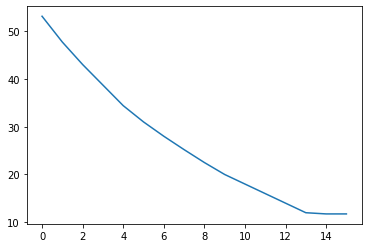

In [134]:
f_vals

#truque para reverter a ordem no eixo x
df = f_vals[::-1]

plt.plot(df)
plt.show()

### Update do lower bound




In [173]:
#ok, agora que a função básica está ok, vou tentar criar a regra de update da habilidade. 

#vou começar com uma versão levemente alterada da função f, chamada g, onde o update também contém f(t+1)

#isso porque o cutoff é função da função valor nos períodos seguintes


def g(θt, t):
   
    #condição para calcular o valor dela no último período
    if(t == T):
        
        return Ls(T-1)
    
    else:
        
        #regra mais elaborada de update da habilidade
        
        #cst é cutoff, começando com habilidade hoje
        cst = θt
        #flag é parar parar o loop se demorar muito
        flag = 1
        tol = 0.01
        #vou usar f() porque a habilidade em f() cresce 0.1 por período
        #se cst crescer 0.1, significa que a função funcionou bem
        
        while (f(θt, t+1) - g(cst, t+1) > tol and flag < 200):
            cst = cst + 0.1
            flag = flag + 1
        
        
        
        
        θ_next = cst
        
        
        #retorna o máximo entre a função hoje ou ela amanhã
        return max(V[t] * θt, g(θ_next, t+1))
        

# a função g2 retorna o valor da habilidade amanhã        
def g2(θt, t):
   
    #condição para calcular o valor dela no último período
    if(t == T):
        
        return Ls(T-1)
    
    else:
        
        #regra mais elaborada de update da habilidade
        
        #cst é cutoff, começando com habilidade hoje
        cst = θt
        #flag é parar parar o loop se demorar muito
        flag = 1
        tol = 0.01
        #vou usar f() porque a habilidade em f() cresce 0.1 por período
        #se cst crescer 0.1, significa que a função funcionou bem
        
        while (f(θt, t+1) - g(cst, t+1) > tol and flag < 1000):
            cst = cst + 0.1
            flag = flag + 1
        
        
        
        
        θ_next = cst
        
        
        #retorna o máximo entre a função hoje ou ela amanhã
        return cst
    
#f2 também retorna o valor da habilidade amanhã

def f2(θt, t):
   
    #condição para calcular o valor dela no último período
    if(t == T):
        
        return Ls(T-1)
    
    else:
        
        #regra simples de update da habilidade
        θ_next = θt + 0.1
        
        
        #retorna o máximo entre a função hoje ou ela amanhã
        return θ_next
        



In [174]:
#testando

g(0.5, 13)


#ótimo, a habilidade cst realmente acertou a regra de aumento da habilidade de f().
g2(0.5, 13)
f2(0.5, 13)

13.2

0.6

0.6

### Escrever a função valor na forma recursiva

### Como é o update da habilidade no penúltimo período?

Notação de trás pra frente: 1 = T-1... cj sem subscrito é o cj em T

Se s quem propõe, ls = \theta_s1

Se s não propõe, ls = max(ls1, cs)

Onde cs é tal que

Ps1 = Ws_vals(cs, cs, lj = \theta_j1, T)

Como todos os valores de Ws são o mesmo no último período, então cs é indefinido, logo ls = ls1


### Como é o update da habilidade no antepenúltimo período?

t = T-2, subscrito 2

Se s quem propõe, ls1 = \theta_s2

Se s não propõe, ls1 = max(ls2, cs1)

Onde cs1 é tal que

Pj2 = Ws_vals(cs1, cs1, lj = \theta_j2, (T-1))

É possível calcular os valores de Ws_vals() para quaisquer valores de habilidades e lower bounds em T-1, então é possível encontrá-lo.





# Próximos passos



* criar função de esperança baseada na função beta

* criar função de esperança de outras funções, ex: $\es{1}{\Ws{1}}$

* criar um vetor de W o valor final e ir preenchendo de trás pra frente

* pensar em como guardar as três dimensões referentes a teta, ls e lj para cada função valor

    * tem como fazer array tridimensional: array(i, j, k)
    
* pensar em como colocar a função no período seguinte em função dos argumentos atuais


* ~fazer Js_val~

* ~guardar resultados de Js_val e Ws_val do último período numa  matriz 4D~
* guardar resultados de Js_val e Ws_val do penúltimo período numa  matriz 3D

* pensar numa função Js_next para achar o valor de Js no próximo período baseado nos parâmetros deste período
    * regra para atualização de lst
    * regra para atualização de ljt
    * expectativa da habilidade no período seguinte







* passos finais
    * replicar os gráficos do artigo de referência
